Below is an FSM with no outlier removal. 

In [185]:
import sys
sys.path.append('../..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.cleaning import prep_high_school_dataframe
from src.cleaning import isolate_numeric_columns, isolate_numeric_rates, filter_cwoption_special_ed
from src.cps_model import cv_feature_set

from sklearn.model_selection import cross_val_predict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The function below isolates high schools and drops high schools with no graduation rates or student counts.

In [186]:
sy_1819_hs = prep_high_school_dataframe('../../data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Profile_Information_SY1819.csv',
                     '../../data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Progress_Reports_SY1819.csv')

0 Student Count
2 schools
15     ENGLEWOOD STEM HS
582       YCCS - VIRTUAL
Name: Short_Name_sp, dtype: object
All 0 Student Count Schools Dropped
0 Graduation Rate
2 schools
261    PATHWAYS - AVONDALE HS
343     NORTHSIDE LEARNING HS
Name: Short_Name_sp, dtype: object
##########
NA Graduation Rates
38 schools
All 0/NA Graduation Rate Schools Dropped


There are 134 CPS high schools left for modeling.

In [187]:
sy_1819_hs.shape

(134, 289)

The distribution of graduation rates has a left skew. 

Text(0.5, 0, 'Graduation Rate')

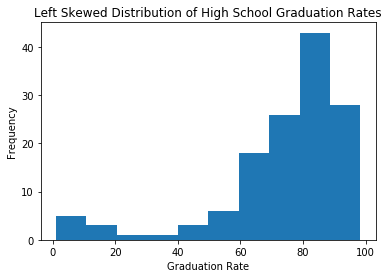

In [188]:
fig, ax = plt.subplots()
sy_1819_hs['Graduation_Rate_School'].plot(kind='hist', ax=ax)
ax.set_title('Left Skewed Distribution of High School Graduation Rates')
ax.set_xlabel('Graduation Rate')

# FSM

The FSM will be a dummy regressor that predicts the mean graduation rate.  

I will use the custom `print_cv_results` function, which implements 10-Fold cross-validation. 

In [189]:
from sklearn.dummy import DummyRegressor

dr = DummyRegressor()

grad_rates = sy_1819_hs['Graduation_Rate_School']
cv_feature_set(dr, sy_1819_hs,grad_rates)


##########Training##########
R2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
RMSE
[20.38317219 21.77756795 21.60316791 20.5013475  21.2544558  20.72566739
 19.80205738 21.7709005  19.84019979 21.77752956]
Mean RMSE:  20.943606597039395
Standard Deviation RMSE:  0.7539762013674577


##########Test##########
R2
[-4.97391302e-03 -3.66797886e-04 -4.11280977e-02 -2.16059299e-04
 -4.28798892e-01 -1.69603487e-03 -2.53641968e-01 -4.72541779e-02
 -1.04069561e-01 -1.21243289e+00]
-0.20945783940467405
RMSE
[25.4336093  11.94302389 14.4339264  24.59948051 18.34222346 23.09430811
 29.98858818 10.97039573 29.5904806  11.12263294]
Mean RMSE:  19.95186691326086
Standard Deviation RMSE:  7.1481870370137885


## Filter Outliers

In [190]:
sy_1819_hs = filter_cwoption_special_ed(sy_1819_hs)
sy_1819_hs.sort_values("Graduation_Rate_School")['School_Type']

248            Neighborhood
220            Neighborhood
60             Neighborhood
23             Neighborhood
201            Neighborhood
               ...         
625    Selective enrollment
521    Selective enrollment
226    Selective enrollment
262    Selective enrollment
303    Selective enrollment
Name: School_Type, Length: 123, dtype: object

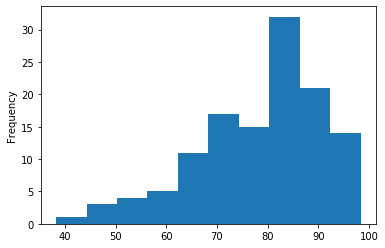

In [191]:
sy_1819_hs['Graduation_Rate_School'].plot(kind='hist')

The distribution is still left skewed, but much less so than before.

In [192]:
from sklearn.dummy import DummyRegressor

dr = DummyRegressor()

grad_rates = sy_1819_hs['Graduation_Rate_School']
cv_feature_set(dr, sy_1819_hs, grad_rates)

##########Training##########
R2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
RMSE
[12.61715165 12.81590118 12.55703566 12.09125583 12.41175216 12.71570723
 13.13425626 12.94484626 12.85412812 13.13141354]
Mean RMSE:  12.727344789654058
Standard Deviation RMSE:  0.30750002770601803


##########Test##########
R2
[-0.01079049 -0.09256124 -0.00504642 -0.00032199 -0.04183318 -0.12531057
 -0.30623589 -0.02142068 -0.00976291 -0.14011537]
-0.07533987288637034
RMSE
[13.6907386  12.07304974 14.14696076 17.60015742 15.42877002 12.97284881
  8.24258645 10.59753542 11.56949695  8.23959592]
Mean RMSE:  12.456174009464116
Standard Deviation RMSE:  2.826094896145956


# Model with Percent Demographics

In [193]:
grad_rates = sy_1819_hs['Graduation_Rate_School']

hs_1819_with_dem_rates = isolate_numeric_rates(sy_1819_hs)
hs_1819_with_dem_rates['Student_Count_Total'] = sy_1819_hs['Student_Count_Total']

In [194]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
cv_feature_set(lr, hs_1819_with_dem_rates, grad_rates)


##########Training##########
R2
[0.60551805 0.57713424 0.57192539 0.55261624 0.60999556 0.5690128
 0.59185675 0.6121974  0.59589327 0.59219107]
0.5878340772000725
RMSE
[7.92455514 8.33394079 8.21574331 8.08744831 7.75118081 8.34781291
 8.3909628  8.0612475  8.17129075 8.38571012]
Mean RMSE:  8.166989245064167
Standard Deviation RMSE:  0.2025209811290987


##########Test##########
R2
[-0.51818181  0.55837927  0.59984875  0.44575493  0.35700175  0.61042777
  0.05396213  0.07590767  0.30122739 -0.23675677]
0.2247571097494228
RMSE
[16.77869563  7.67571466  8.9265199  13.10079241 12.12096249  7.6329629
  7.01466547 10.07999318  9.62437873  8.58170657]
Mean RMSE:  10.153639193047649
Standard Deviation RMSE:  2.8819586244519586


## Decision Tree model 

As an exploratory technique, I will tune a decision tree model on the entire data set. This will show the **greediest** feature.

In [195]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

dt = DecisionTreeRegressor()
dt.fit(hs_1819_with_dem_rates, grad_rates)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [196]:
for feature, col in zip(dt.feature_importances_, hs_1819_with_dem_rates.columns):
    print(feature, col)

0.049755213194643565 perc_Student_Count_Low_Income
0.5484648641067456 perc_Student_Count_Special_Ed
0.08760037947485608 perc_Student_Count_English_Learners
0.01952672329867982 perc_Student_Count_Black
0.007777691158542168 perc_Student_Count_Hispanic
0.022122838251481158 perc_Student_Count_White
0.03507839932916335 perc_Student_Count_Asian
0.013879945882094747 perc_Student_Count_Native_American
0.0 perc_Student_Count_Other_Ethnicity
0.0 perc_Student_Count_Asian_Pacific_Islander
0.008735817690542396 perc_Student_Count_Multi
0.08077297169572364 perc_Student_Count_Hawaiian_Pacific_Islander
0.0341096064242639 perc_Student_Count_Ethnicity_Not_Available
0.09217554949326363 Student_Count_Total


In [197]:
def print_fi(estimator, df):
    '''
    Given a fit tree based estimator, print column names and feature importances.
    '''
    for feature, col in zip(estimator.feature_importances_, df.columns):
        print(feature, col)

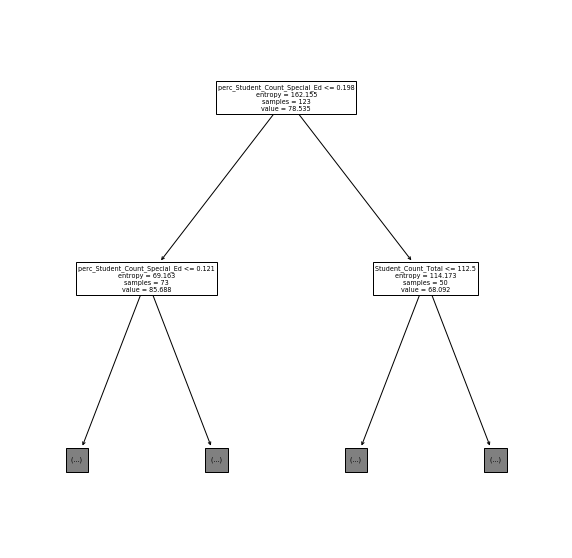

In [198]:
fig, ax = plt.subplots(figsize=(10,10))
plot_tree(dt, max_depth=1, feature_names=hs_1819_with_dem_rates.columns);

The decision tree suggests that the final model could take the form of having no racial demographics, or a vastly reduced set of racial demographics.  The model could take only inputs of percent special ed, percent low income, percent english language learners, and total student count.

# Add Network Booleans

Below, I will use a One-Hot-Encoder within a pipeline on the `Network` column. 

In [206]:
hs_1819_with_dem_rates['Network'] = sy_1819_hs['Network']
hs_1819_with_dem_rates.head()

,perc_Student_Count_Low_Income,perc_Student_Count_Special_Ed,perc_Student_Count_English_Learners,perc_Student_Count_Black,perc_Student_Count_Hispanic,perc_Student_Count_White,perc_Student_Count_Asian,perc_Student_Count_Native_American,perc_Student_Count_Other_Ethnicity,perc_Student_Count_Asian_Pacific_Islander,perc_Student_Count_Multi,perc_Student_Count_Hawaiian_Pacific_Islander,perc_Student_Count_Ethnicity_Not_Available,Student_Count_Total,Network
9,0.715254,0.091525,0.061017,0.637288,0.338983,0.013559,0.000000,0.000000,0.0,0.0,0.010169,0.000000,0.000000,295,Network 17
13,0.836364,0.140909,0.098485,0.112121,0.856061,0.012121,0.007576,0.006061,0.0,0.0,0.004545,0.000000,0.001515,660,Charter
14,0.373298,0.053927,0.010995,0.119372,0.295288,0.391623,0.142932,0.003141,0.0,0.0,0.041885,0.005759,0.000000,1910,ISP
18,0.935484,0.151613,0.248387,0.009677,0.966129,0.017742,0.003226,0.003226,0.0,0.0,0.000000,0.000000,0.000000,620,Charter
20,0.800718,0.213645,0.014363,0.989228,0.008977,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.001795,0.000000,557,Charter


In [207]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [208]:
# One hot encode the networks

network_transformer = make_column_transformer((OneHotEncoder(drop='first'), ['Network']), 
                                               remainder='passthrough')


In [209]:
si_net = SimpleImputer(strategy='constant', fill_value='missing_network')
hs_1819_with_dem_rates['Network'] = si_net.fit_transform(hs_1819_with_dem_rates[['Network']])

In [210]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

pipe = make_pipeline(network_transformer, lr)

cv_feature_set(pipe, hs_1819_with_dem_rates, grad_rates)

##########Training##########
R2
[0.6459285  0.61377763 0.62427623 0.61273203 0.64573148 0.61654123
 0.63494774 0.66404053 0.62565639 0.63664858]
0.6320280345262815
RMSE
[7.50769825 7.96467144 7.69699959 7.52449222 7.38753204 7.87408058
 7.93565916 7.50309322 7.86462165 7.9154372 ]
Mean RMSE:  7.717428534492089
Standard Deviation RMSE:  0.20750099929030844


##########Test##########
R2
[-0.83853789  0.64177412  0.53860445 -0.03107389  0.35419268  0.59591245
 -0.01652674 -0.06472569  0.46113271 -0.37622112]
0.12645310715500052
RMSE
[18.46428932  6.91309575  9.58532389 17.86864168 12.14741016  7.77386321
  7.27130076 10.81985452  8.4517313   9.05264775]
Mean RMSE:  10.834815833189749
Standard Deviation RMSE:  3.965742094078826


Adding network booleans to the pipeline made the R2 go up slightly on the train sets, but descreased the R2 on the test by almost 10 percent

In [211]:
### Decision Tree with Network Booleans

In [212]:
dt = DecisionTreeRegressor()

ohe=OneHotEncoder(sparse=False)
ohe_array = ohe.fit_transform(hs_1819_with_dem_rates[['Network']])
ohe_df = pd.DataFrame(ohe_array,index=hs_1819_with_dem_rates.index, columns=list(ohe.get_feature_names()) )
network_df = hs_1819_with_dem_rates.merge(ohe_df, left_index=True, right_index=True).drop('Network', axis=1)
 
dt.fit(network_df, grad_rates)
print_fi(dt, network_df)

0.03475228783375047 perc_Student_Count_Low_Income
0.5496804737021731 perc_Student_Count_Special_Ed
0.08257529500643551 perc_Student_Count_English_Learners
0.04651072537871468 perc_Student_Count_Black
0.009831269932330907 perc_Student_Count_Hispanic
0.005409169090440713 perc_Student_Count_White
0.03644851866235979 perc_Student_Count_Asian
0.00595707727398027 perc_Student_Count_Native_American
0.0 perc_Student_Count_Other_Ethnicity
0.0 perc_Student_Count_Asian_Pacific_Islander
0.0024831914007726035 perc_Student_Count_Multi
0.0659408754308764 perc_Student_Count_Hawaiian_Pacific_Islander
2.1893431157479218e-05 perc_Student_Count_Ethnicity_Not_Available
0.11770071452551957 Student_Count_Total
0.0 x0_AUSL
0.037525878495309355 x0_Charter
0.0 x0_Contract
2.4149624445563277e-05 x0_ISP
0.0 x0_Network 14
0.004963750576042686 x0_Network 15
0.0 x0_Network 16
0.0001494101332452614 x0_Network 17
2.5319502445690894e-05 x0_missing_network


From the decision tree print feature importance printout,the most important network is Charter. This suggests maknig a charter boolean may be helpful. 

# Add Dress Code, Healthy Schools, Create School Certification